## Семинар: "Методы оптимизации"

In [97]:
from functools import partial

import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
from sklearn.decomposition import PCA
import torch.nn.functional as F
from copy import deepcopy

%matplotlib inline
plt.rc('animation', html='html5')

На этом семинаре мы попробуем реализовать и сравнить различные методы оптимизации: SGD, Momentum, NAG, Adagrad, RMSProp, AdaDelta.

### Реализация методов

Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

In [2]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)

    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

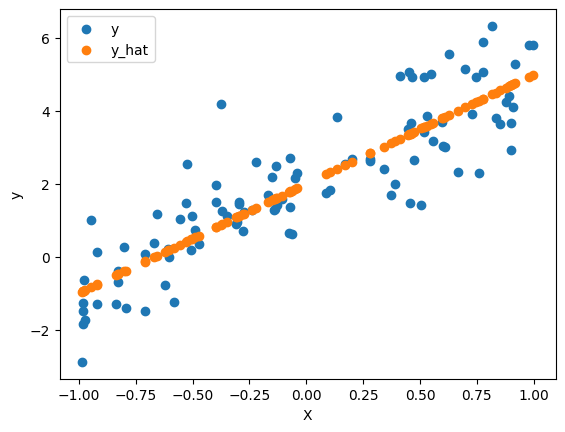

In [3]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

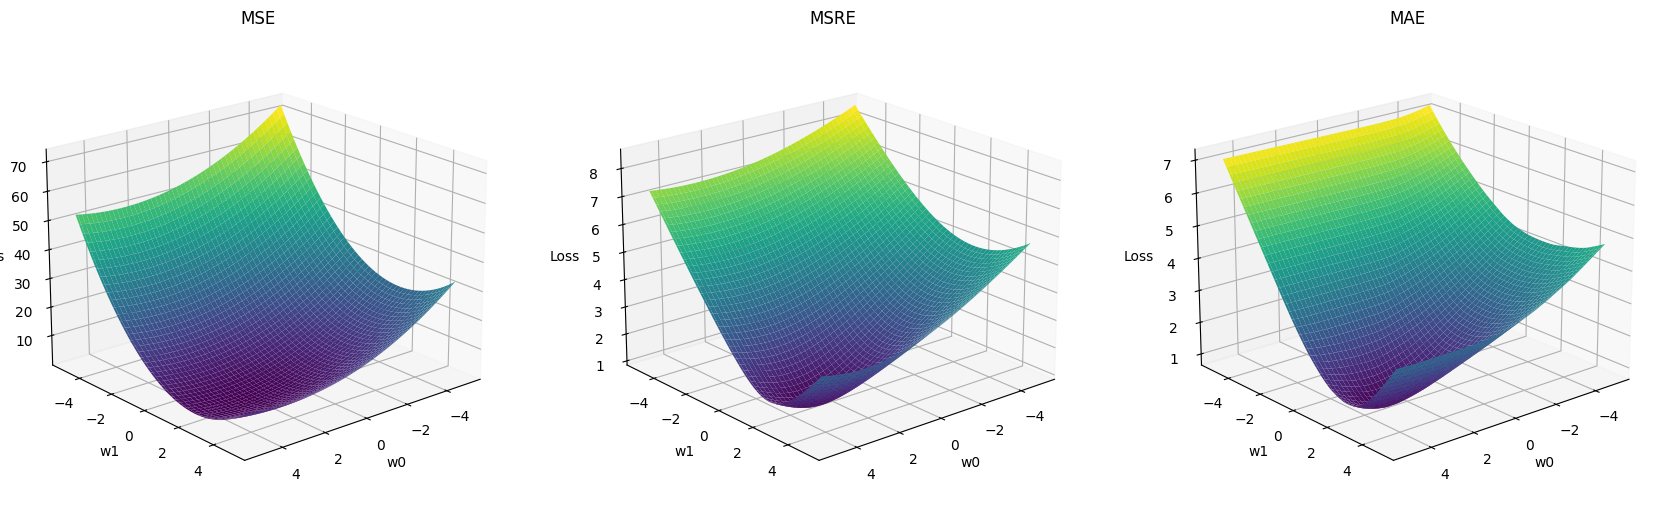

In [4]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

In [143]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()

    def update_lr(self, lr):
        pass

    def get_lr(self):
        pass

In [6]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [7]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in tqdm(optim_list):
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }

    return loss_animator.animate(num_iter, data, step_skip=step_skip)

#### SGD
$$\theta_t = \theta_{t-1} - \eta \sum_{i_1, ..., i_k} \nabla_{\theta} J_{i} (\theta_{t-1})$$

In [162]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad

    def update_lr(self, lr):
        self.lr = lr

    def get_lr(self):
        return self.lr

#### Momentum
$$\nu_t=\gamma \nu_{t-1} + \eta_t \nabla_{\theta} J_{i} (\theta_{t-1})$$
$$\theta_t = \theta_{t-1} - \nu_t$$

In [9]:
class Momentum(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.prev_momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                prev_momentum = self.prev_momentum[i]
                self.prev_momentum[i] = self.gamma * prev_momentum + self.lr * p.grad
                p -= self.prev_momentum[i]

#### Nesterov Accelerated Gradient (NAG)
$$\nu_t=\gamma \nu_{t-1} + \eta_t \nabla_{\theta} J_{i} (\theta_{t-1} - \gamma \nu_{t-1})$$
$$\theta_t = \theta_{t-1} - \nu_t$$

In [10]:
class NAG(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.prev_momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                prev_momentum = self.prev_momentum[i]
                self.prev_momentum[i] = self.gamma * prev_momentum + self.lr * p.grad
                p -= (1 + self.gamma) * self.prev_momentum[i] - self.gamma * prev_momentum

#### AdaGrad
$$G_t = \sum_{k=0}^t g_{k}^2$$
$$\theta_{t} = \theta_{t-1} - \frac{\eta}{\sqrt{G_{t-1} + ϵ}} \cdot g_{t-1}$$

In [19]:
class AdaGrad(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2):
        super().__init__(params)
        self.epsilon = epsilon
        self.eta = eta

        self.G = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.G[i] += p.grad ** 2
                p -= self.eta * p.grad / torch.sqrt(self.G[i] + self.epsilon)

#### RMSProp
$$G_t = \gamma G_{t-1} + (1 - \gamma) g_t^2$$
$$\theta_{t} = \theta_{t-1} - \frac{\eta}{\sqrt{G_{t-1} + ϵ}} \cdot g_{t-1}$$

In [20]:
class RMSProp(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2, gamma=0.9):
        super().__init__(params)
        self.eta = eta
        self.epsilon = epsilon
        self.gamma = gamma

        self.G = [torch.zeros(p.shape) for p in self.params]


    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.G[i] = self.gamma * self.G[i] + (1 - self.gamma) * (p.grad ** 2)
                p -= self.eta / torch.sqrt(self.G[i] + self.epsilon) * p.grad

In [21]:
from functools import partial

points, losses = optimize_function(
    partial(loss_animator.loss_func, loss=mse),
    SGD,
     {'lr': 1e-2},
    start_point=[-4, -4],
    num_iter=100
)

In [22]:
compare_optimizers(
    loss_animator,
    mae,
    [
        ['SGD', SGD, {'lr': 1e-1}],
        ['Momentum', NAG, {'lr': 1e-1}],
        ['NAG', NAG, {'lr': 1e-1}],
        ['AdaGrad', AdaGrad, {'eta' : 1}],
        ['RMSProp', RMSProp, {'eta' : 1}],
    ],
    start_point=[-4, -4],
    num_iter=100
)

  0%|          | 0/5 [00:00<?, ?it/s]

###  Домашнее задание: Обучение нейронной сети + Подбор шага

В этом задании вам нужно:
1) Реализовать Adam, AdamW и обучить сверточную нейросеть на MNIST. Сравнить графики обучения для SGD, Adam и AdamW. **(2 балла)**
2) Реализовать LinearLR и CosineAnnealingLR. Обучить сверточную нейросеть на MNIST с SGD, Adam, AdamW с LinearLR, CosineAnnealingLR. Сравните графики изменения loss-функции и точности (суммарно должно быть 9 экспериментов, 3 из которых покрываются пунктом 1). **(3 балла)**

Ссылки:
- https://arxiv.org/abs/1711.05101 (AdamW, статья)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.AdamW.html (AdamW, PyTorch)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LinearLR.html (LinearLR, PyTorch)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html (CosineAnnealingLR, PyTorch)

In [23]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

zsh:1: command not found: wget
tar: Error opening archive: Failed to open 'MNIST.tar.gz'


In [24]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

100%|██████████████████████████████████████| 9.91M/9.91M [00:08<00:00, 1.24MB/s]
100%|███████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 282kB/s]
100%|██████████████████████████████████████| 1.65M/1.65M [00:01<00:00, 1.11MB/s]
100%|██████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 1.45MB/s]


### 1

In [163]:
class Adam(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2, beta1=0.9, beta2=0.999):
        super().__init__(params)
        self.eta = eta
        self.epsilon = epsilon
        self.beta1 = beta1
        self.beta2 = beta2

        self.prev_momentum = [torch.zeros(p.shape) for p in self.params]
        self.G = [torch.zeros(p.shape) for p in self.params]
        self.t = 0

    def step(self):
        self.t += 1
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.prev_momentum[i] = self.beta1 * self.prev_momentum[i] + (1 - self.beta1) * p.grad
                self.G[i] = self.beta2 * self.G[i] + (1 - self.beta2) * (p.grad ** 2)
                prev_momentum_correction = self.prev_momentum[i] / (1 - self.beta1**self.t)
                G_correction = self.G[i] / (1 - self.beta2**self.t)
                p -= self.eta / torch.sqrt(G_correction + self.epsilon) * prev_momentum_correction

    def update_lr(self, eta):
        self.eta = eta

    def get_lr(self):
        return self.eta

In [164]:
class AdamW(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2, beta1=0.9, beta2=0.999, lambd=0.1):
        super().__init__(params)
        self.eta = eta
        self.epsilon = epsilon
        self.beta1 = beta1
        self.beta2 = beta2
        self.lambd = lambd

        self.prev_momentum = [torch.zeros(p.shape) for p in self.params]
        self.G = [torch.zeros(p.shape) for p in self.params]
        self.t = 0

    def step(self):
        self.t += 1
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.prev_momentum[i] = self.beta1 * self.prev_momentum[i] + (1 - self.beta1) * p.grad
                self.G[i] = self.beta2 * self.G[i] + (1 - self.beta2) * (p.grad ** 2)
                prev_momentum_correction = self.prev_momentum[i] / (1 - self.beta1**self.t)
                G_correction = self.G[i] / (1 - self.beta2**self.t)
                p -= self.eta / torch.sqrt(G_correction + self.epsilon) * prev_momentum_correction
                p -= self.eta * self.lambd * p

    def update_lr(self, eta):
        self.eta = eta

    def get_lr(self):
        return self.eta

In [127]:
def create_model():
    return nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Flatten(),
        nn.Linear(4*4*32, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )

In [154]:
def train(train_dataloader, val_dataloader, model, optimizer, scheduler=None, n_epochs=5):
    train_loss_epochs = []
    val_loss_epochs = []
    train_accuracy_epochs = []
    val_accuracy_epochs = []
    
    for epoch in range(n_epochs):
        model.train()
        train_losses = []
        train_accuracies = []
        
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_losses.append(loss.item())
            pred = torch.argmax(y_pred, dim=-1)
            train_accuracies.append((pred == y_train).float().mean().item())
            
        if scheduler is not None:
            scheduler.step()
        
        train_loss_epochs.append(np.mean(train_losses))
        train_accuracy_epochs.append(np.mean(train_accuracies))
        
        model.eval()
        val_losses = []
        val_accuracies = []
        
        with torch.no_grad():
            for x_val, y_val in tqdm(val_dataloader, desc=f'Epoch {epoch+1}/{n_epochs} [Val]', leave=False):
                y_pred = model(x_val)
                loss = F.cross_entropy(y_pred, y_val)
                
                val_losses.append(loss.item())
                pred = torch.argmax(y_pred, dim=-1)
                val_accuracies.append((pred == y_val).float().mean().item())
        
        val_loss_epochs.append(np.mean(val_losses))
        val_accuracy_epochs.append(np.mean(val_accuracies))
    
    return train_loss_epochs, val_loss_epochs, train_accuracy_epochs, val_accuracy_epochs

In [174]:
def train_optimizers_sh(model_class, optimizer_configs, train_loader, val_loader, scheduler_configs=None, n_epochs=5):
    results = {}
    
    if scheduler_configs is None:
        scheduler_configs = [(None, None, None)]
    
    for opt_name, optimizer_class, optimizer_args in optimizer_configs:
        for sched_name, scheduler_class, scheduler_args in scheduler_configs:
            if sched_name is None:
                experiment_name = f"{opt_name}"
            else:
                experiment_name = f"{opt_name} + {sched_name}"
            
            torch.manual_seed(42)
            model = model_class()
            optimizer = optimizer_class(model.parameters(), **optimizer_args)
            
            if scheduler_class is not None:
                scheduler = scheduler_class(optimizer, **scheduler_args)
            else:
                scheduler = None
            
            train_loss, val_loss, train_acc, val_acc = train(
                train_loader,
                val_loader,
                model,
                optimizer,
                scheduler=scheduler,
                n_epochs=n_epochs,
            )
            
            results[experiment_name] = {
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc
            }
    
    return results

def plot_comparison(results):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    colors = plt.cm.rainbow(np.linspace(0, 1, len(results)))
    
    ax = axes[0]
    for (name, data), color in zip(results.items(), colors):
        epochs = range(1, len(data['val_loss']) + 1)
        ax.plot(epochs, data['val_loss'], label=name, color=color,
               linewidth=2.5, marker='o', markersize=7)
    
    ax.set_xlabel('Epochs', fontsize=16)
    ax.set_ylabel('Loss', fontsize=16)
    ax.set_title('Loss', fontsize=18)
    ax.legend(loc='best', fontsize=14)
    ax.grid(True, alpha=0.3)
    
    ax = axes[1]
    for (name, data), color in zip(results.items(), colors):
        epochs = range(1, len(data['val_acc']) + 1)
        ax.plot(epochs, data['val_acc'], label=name, color=color,
               linewidth=2.5, marker='s', markersize=7)
    
    ax.set_xlabel('Epochs', fontsize=16)
    ax.set_ylabel('Accuracy', fontsize=16)
    ax.set_title('Accuracy', fontsize=18)
    ax.legend(loc='best', fontsize=14)
    ax.grid(True, alpha=0.3)
    
    ax.set_ylim([0.96, 1.0])
    ax.set_yticks(np.linspace(0.96, 1, num=6))
    
    plt.tight_layout()
    plt.show()

In [166]:
optimizer_configs = [
    ('SGD', SGD, {'lr': 0.01}),
    ('Adam', Adam, {'eta': 0.001}),
    ('AdamW', AdamW, {'eta': 0.001}),
]

In [176]:
results_base = train_optimizers_sh(
    create_model,
    optimizer_configs,
    train_loader,
    test_loader,
    n_epochs=5
)

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

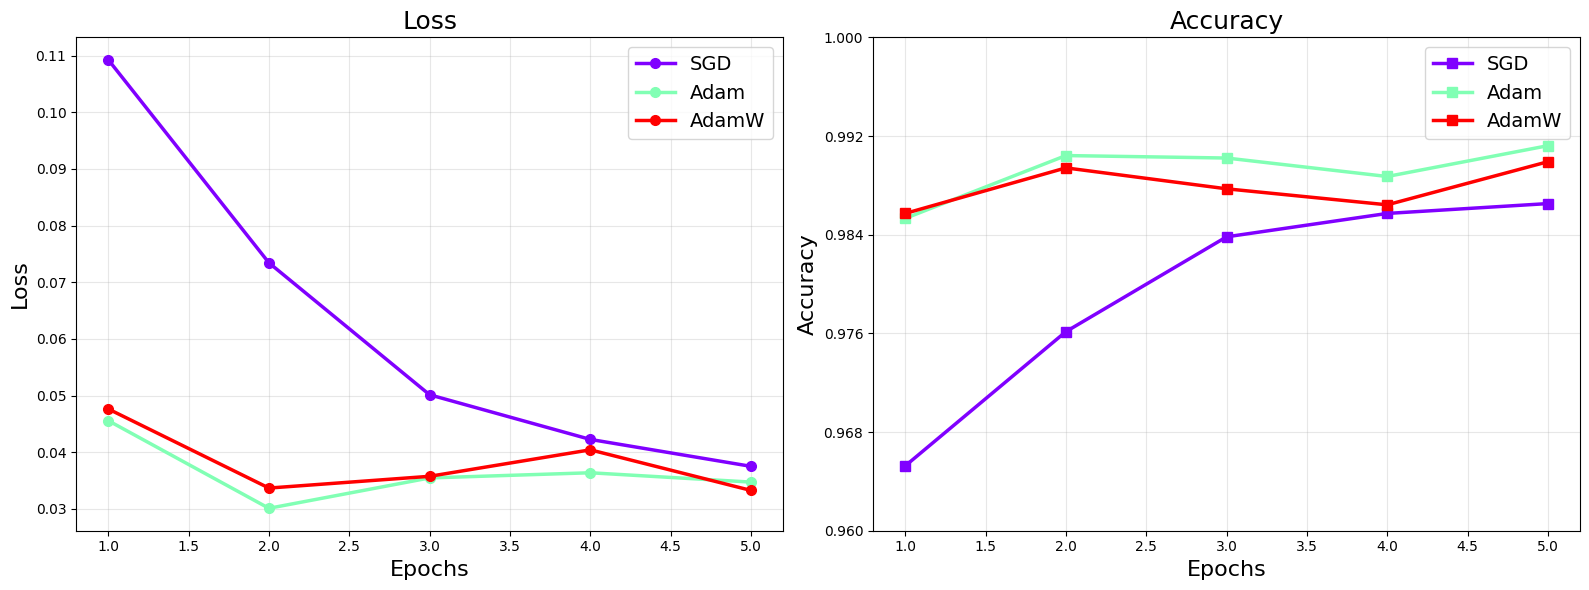

In [177]:
plot_comparison(results_base)

Вывод по графикам для разных оптимизаторов:
- Adam и AdamW быстрее сходятся, чем SGD;
- Adam и AdamW имеют более маленький loss в конце обучения, чем SGD;
- Adam и AdamW имеют большую точность в конце обучения, чем SGD.
  
Все эти пункты говорят о том, что для данной задачи Adam и AdamW дают лучший результат, чем SGD.

### 2

In [148]:
class LRScheduler:
    def __init__(self, optimizer: Optimizer):
        self.optimizer = optimizer

    def step(self):
        pass

In [153]:
class LinearLR(LRScheduler):
    def __init__(
        self,
        optimizer: Optimizer,
        start_factor: float = 0.1,
        end_factor: float = 1.0,
        total_iters: int = 100
    ):
        super().__init__(optimizer)
        self.start_factor = start_factor
        self.end_factor = end_factor
        self.total_iters = total_iters
        self.start_lr = optimizer.get_lr() 
        self.t = 0

    def step(self):
        self.t += 1
        factor = self.start_factor + (self.end_factor - self.start_factor) * (self.t / self.total_iters)
        new_lr = self.start_lr * factor
        self.optimizer.update_lr(new_lr)
        

class CosineAnnealing(LRScheduler):
    def __init__(
            self,
            optimizer: Optimizer,
            T_max: int = 20,
            eta_min: float = 0.01
        ):
        super().__init__(optimizer)
        self.T_max = T_max
        self.eta_min = eta_min
        self.start_lr = optimizer.get_lr() 
        self.t = 0

    def step(self):
        self.t += 1
        new_lr = self.eta_min + (self.start_lr - self.eta_min) * (1 + np.cos(np.pi * self.t / self.T_max)) / 2
        self.optimizer.update_lr(new_lr)

In [167]:
n_epochs = 5
scheduler_configs = [
    ('LinearLR', LinearLR, {'start_factor': 0.1, 'end_factor': 1.0, 'total_iters': n_epochs-2}),
    ('CosineAnnealing', CosineAnnealing, {'T_max': n_epochs, 'eta_min': 0.001}),
]

In [168]:
results = train_optimizers_sh(
    create_model,
    optimizer_configs,
    train_loader,
    test_loader,
    scheduler_configs,    
    n_epochs=5
)

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5/5 [Val]:   0%|          | 0/313 [00:00<?, ?it/s]

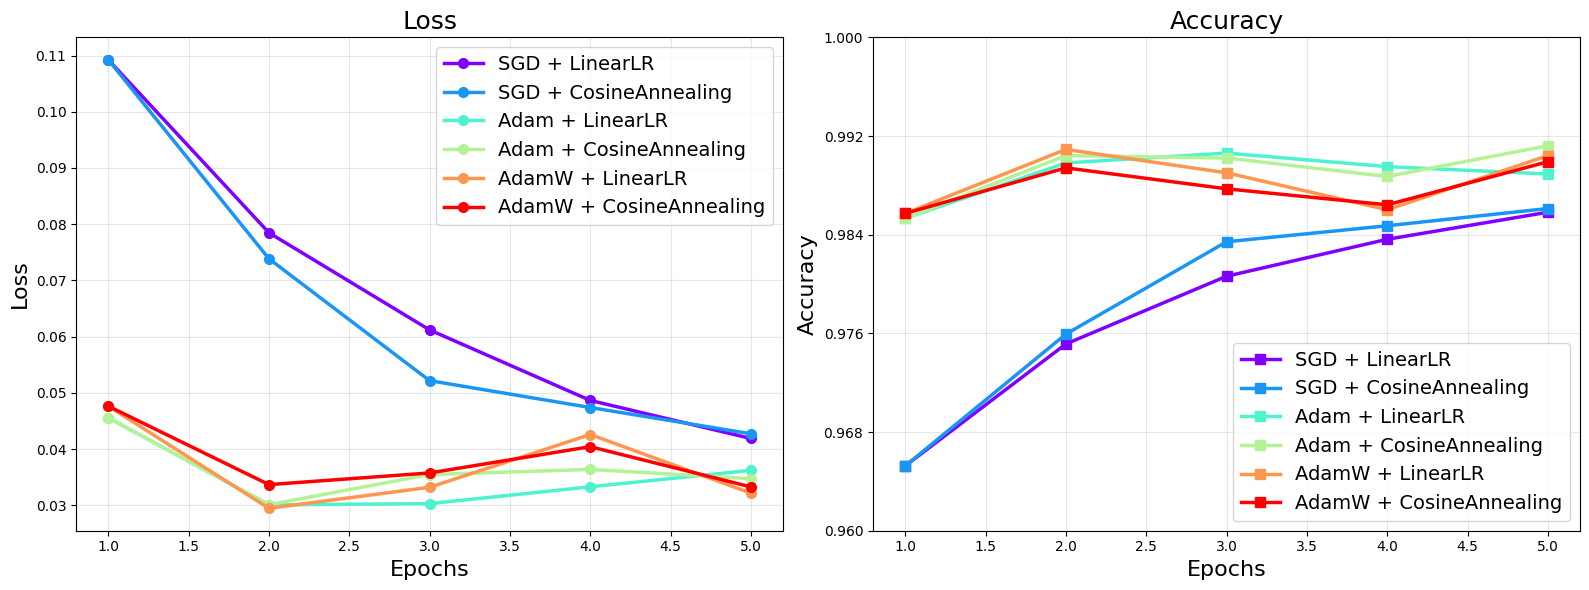

In [169]:
plot_comparison(results)

Выводы по графикам для оптимизаторов + Learning scheduler-ов:
- Для SGD scheduler ускоряет начальную сходимость и увеличивает точность для меньшего числа эпох;
- Для SGD наилучший результат дал CosineAnnealing;
- На Adam и AdamW scheduler-ы не сильно повлияли. Наилучшее качество дал Adam c CosineAnnealing;
- LinearLR полезен для SGD, который чувствителен к начальному learning_rate. Для адаптивных методов эффект минимален.
- CosineAnnealing даёт небольшое улучшение Accuracy для  Adam и плавное снижение Loss для SGD. Однако для AdamW лосс
  начинает расти после 3 эпохи и падает лишь на 5-ой. Скорее всего это связано с агрессивным снижением learning rate.

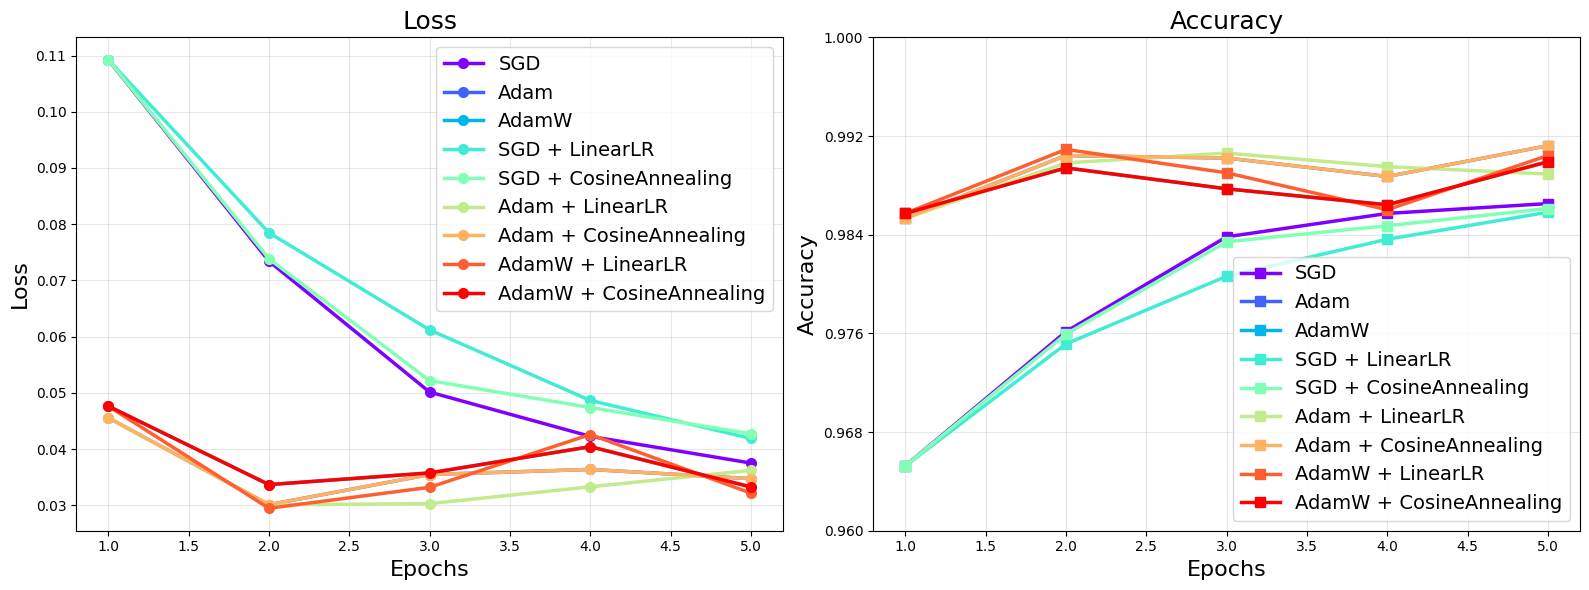

In [172]:
plot_comparison(results_base | results)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

- Your text here

Здесь вы можете оставить комментарии по лекции или семинару:

- Your text here